# Random Forest Regression Model Training
Testing the training of a simple St Ebbes RF model.

In [2]:
# Python library imports
#------------------------
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
import sys
from scipy import stats
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
import pickle
import datetime as dt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from matplotlib.ticker import FuncFormatter
from matplotlib.dates import DateFormatter, MonthLocator
import pytz

pd.plotting.register_matplotlib_converters()
# pd.set_option('display.max_colwidth', -1)

# File locations
#----------------
data_home = './oxaria/processed/'
rf_home = './oxaria/processed/models/methods_paper/'
pngs = './oxaria/pngs/


In [3]:
# Sensor data for colocated device at St Ebbes
#----------------------------------------------

df20 = pd.read_feather(data_home + 'batch_1_jan20_feb21/sebbes_train_536_s15_ratified.ftr').set_index(
    'rec').sort_index()


# Convert all float64 cols to float32
cols = df20.select_dtypes(np.float64).columns
df20[cols] = df20[cols].astype(np.float32)
print(df20['tag'].unique(), '\n')
df20.info(verbose=False)

# # Convert all float64 cols to float32
# cols = df21.select_dtypes(np.float64).columns
# df21[cols] = df21[cols].astype(np.float32)
# print(df21['tag'].unique(), '\n')
# df21.info(verbose=False)

sebbes_train_s15 = pd.concat([df20])
sebbes_train_s15['pm10_ugg_combo'] = sebbes_train_s15['pm10_ugg_s']
sebbes_train_s15['pm10_ugg_combo'] = np.where(
    sebbes_train_s15['pm10_ugg_combo'] < 3.0, np.nan, sebbes_train_s15['pm10_ugg_combo'])
print(sebbes_train_s15['tag'].unique(), '\n')
sebbes_train_s15.info(verbose=False)

['scs-bgx-538'] 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20160 entries, 2020-06-05 00:15:00+00:00 to 2021-01-01 00:00:00+00:00
Columns: 71 entries, tag to no2_ppb_h_bl
dtypes: float32(65), object(6)
memory usage: 6.1+ MB
['scs-bgx-538'] 

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20160 entries, 2020-06-05 00:15:00+00:00 to 2021-01-01 00:00:00+00:00
Columns: 72 entries, tag to pm10_ugg_combo
dtypes: float32(66), object(6)
memory usage: 6.2+ MB


In [4]:
# Function to generate the remaining feature required by the correction model
#-----------------------------------------------------------------------------

def no2_feature_gen(df):
    # calc % change in all df cols over last 15 mins
    tmpdf1 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(
        axis=1, how='all').pct_change(periods=1)
    tmpdf1.columns = ['pc15_' + name for name in list(tmpdf1.columns)]
    # and same over last 30 mins
    tmpdf2 = df.apply(lambda x: pd.to_numeric(x, errors='coerce')).dropna(
        axis=1, how='all').pct_change(periods=2)
    tmpdf2.columns = ['pc30_' + name for name in list(tmpdf2.columns)]
    # merge % change stats back on to original df
    df = df.merge(tmpdf1, left_index=True, right_index=True,
                  how='left').merge(tmpdf2,
                                    left_index=True,
                                    right_index=True,
                                    how='left').set_index(['tag', 'rec'])
    return df

def rushhour(df):
    # calc integer flags for hour of observation
    df['hour'] = df.index.get_level_values(1).hour
    # and day of week
    df['day'] = df.index.get_level_values(1).dayofweek
    # and integer flag(s) for off-peak, morning & evening rush hours
    df.loc[(df.index.get_level_values(1).time >= dt.time(7, 30, 0)) &
           (df.index.get_level_values(1).time >= dt.time(9, 30, 0)) &
           (df.index.get_level_values(1).weekday < 5), 'rushhour'] = 1
    df.loc[(df.index.get_level_values(1).time >= dt.time(16, 0, 0)) &
           (df.index.get_level_values(1).time >= dt.time(18, 0, 0)) &
           (df.index.get_level_values(1).weekday < 5), 'rushhour'] = 2
    df['rushhour'] = np.where(df['rushhour'] >= 1, df['rushhour'],
                              0).astype(np.int32)
    return df

In [5]:
# Apply feature generation functions to St Ebbes training
#---------------------------------------------------------
tmp_list = []
for tag, dat in sebbes_train_s15.reset_index().groupby('tag'):
    tmpdf = no2_feature_gen(dat)
    tmpdf = rushhour(tmpdf)
    tmp_list.append(tmpdf)
sebbes_train_s15_1 = pd.concat(tmp_list)
sebbes_train_s15_1.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 20160 entries, ('scs-bgx-538', Timestamp('2020-06-05 00:15:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2021-01-01 00:00:00+0000', tz='UTC'))
Data columns (total 200 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    val.no2.wev               float32
 1    val.no2.cnc               float32
 2    val.no2.aev               float32
 3    val.no2.wec               float32
 4    val.sht.hmd_g             float32
 5    val.sht.tmp_g             float32
 6    val.no2.cnc_1             float32
 7    name                      object 
 8    val.hmd                   float32
 9    val.tmp                   float32
 10   val.mtf1                  float32
 11   val.pm1                   float32
 12   val.mtf5                  float32
 13   val.pm2p5                 float32
 14   val.mtf3                  float32
 15   val.pm10                  float32
 16   val.mtf7                  float32
 17   va

In [6]:
# Constraing training to Jun to Nov, verification to Dec
# --------------------------------------------------------

jun = dt.datetime(2020, 6, 1, 0, 0, 0, tzinfo=pytz.utc)
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)

train_jun2nov = sebbes_train_s15_1.query('@jun <= rec < @dec').reset_index().set_index(['tag','rec'])

# Keep the interesting cols only, baseline & intermediate dfs
# confuse the training quite a bit, make sure to drop them
# ------------------------------------------------------------
train_df = train_jun2nov.loc[:, [
    'val.mtf1',
    'val.mtf5',
    'val.mtf3',
    'val.mtf7',
    'val.sfr',
    'val.hmd',
    'val.tmp',
    'pc15_val.mtf1',
    'pc15_val.mtf5',
    'pc15_val.mtf3',
    'pc15_val.mtf7',
    'pc15_val.sfr',
    'pc15_val.hmd',
    'pc15_val.tmp',
    'pc30_val.mtf1',
    'pc30_val.mtf5',
    'pc30_val.mtf3',
    'pc30_val.mtf7',
    'pc30_val.sfr',
    'pc30_val.hmd',
    'pc30_val.tmp',
    'hour',
    'day',
    'pm10_ugg_s',
    'pm25_ugg_s',
    'pm10_ugg_h',
    'pm10_ugg_combo',
    'val.pm10_1_c1',
    'pc15_val.pm10_1_c1',
    'pc30_val.pm10_1_c1',
]]

# Drop weirdness in some columns
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 12636 entries, ('scs-bgx-538', Timestamp('2020-06-05 00:45:00+0000', tz='UTC')) to ('scs-bgx-538', Timestamp('2020-11-30 23:45:00+0000', tz='UTC'))
Data columns (total 30 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   val.mtf1            12636 non-null  float32
 1   val.mtf5            12636 non-null  float32
 2   val.mtf3            12636 non-null  float32
 3   val.mtf7            12636 non-null  float32
 4   val.sfr             12636 non-null  float32
 5   val.hmd             12636 non-null  float32
 6   val.tmp             12636 non-null  float32
 7   pc15_val.mtf1       12636 non-null  float32
 8   pc15_val.mtf5       12636 non-null  float32
 9   pc15_val.mtf3       12636 non-null  float32
 10  pc15_val.mtf7       12636 non-null  float32
 11  pc15_val.sfr        12636 non-null  float32
 12  pc15_val.hmd        12636 non-null  float32
 13  pc15_val.tmp        12636 non

In [7]:
# Define the training dataset. In this 1st cut using the full St Ebbes timeseries Jun-Nov
# ------------------------------------------------------------------------------------------

# Set training & target variables
X = train_df.drop(columns=[
    'pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h','pm10_ugg_combo'
])  # remove target variable (i.e. no2) from training set.

y = train_df['pm10_ugg_combo']  # define target variable (i.e. no2).

# Split into training & validation (test) datasets for both dependent & independent variables
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=7)


In [8]:
# Define a function to test model performance based on a range of max. no, of leaf node sizes
#---------------------------------------------------------------------------------------------
# The following function estimates mean absolute error as a metric for model
# accuracy.The number of trees used is set to 100 (i.e. n_estimators). 500 trees have also been tested but
# without any imporvement in accuracy so 100 is used to reduce training times.


def get_mae(max_leaf_nodes, train_X, val_X, train_y, val_y):

    # Define the model
    model = RandomForestRegressor(max_leaf_nodes=max_leaf_nodes,
                                  random_state=7,
                                  n_estimators=100,
                                  n_jobs=-1)

    # Create a v simple pipeline that imputes missing input values before fitting the model to them
    #-----------------------------------------------------------------------------------------------
    my_pipeline = Pipeline(steps=[('preprocessor',
                                   SimpleImputer()), ('model', model)])

    # Calculate a metric variable using the cross_val_score function
    #----------------------------------------------------------------
    # The block below performs a cross validation excersise. For a given model configuration, it splits the
    # training set in 5 subsets and carries out a training sequence with the mean absolute error as a metric
    # of performance.
    # An avergae of those 5 MAE is then returned (see Figure below 'Validation' label).
    # This procedure ensures a robust training sequence as it removes the chance of
    # selecting a validation set that is very similar to the testing subset.
    #
    # Fit 5 random subsets of train_x & train_y to the pipeline RFR model & calc mean absolute error
    # multiply by -1 since sklearn calculates *negative* MAE
    metric = -1 * cross_val_score(
        my_pipeline, train_X, train_y, cv=5, scoring='neg_mean_absolute_error')

    # Train the model
    my_pipeline.fit(train_X, train_y)

    # Predict dependent variable using validation & training subsets of independent variables
    preds_val = my_pipeline.predict(val_X)
    preds_tr = my_pipeline.predict(train_X)

    # MAE calculation for training and validation data
    mae_ver = mean_absolute_error(val_y, preds_val)
    mae_tr = mean_absolute_error(train_y, preds_tr)

    # Bring it all together in outputs
    return (mae_ver, mae_tr, metric.mean())


In [9]:
# Calculate model performance using MAE finction
#------------------------------------------------

# Initialise vars with range of nodes to test
mini = 50
maxi = 5000
step = 100

candidate_max_leaf_nodes = np.arange(mini, maxi, step).tolist()

# Loop using dict comprehension to find the ideal tree size from number of nodes tested.
# The following line calls the get_mae function above for
# every value of nodes defined in candiate_max_leaf_nodes.
scores = {
    leaf_size: get_mae(leaf_size, train_X, val_X, train_y, val_y)
    for leaf_size in candidate_max_leaf_nodes
}
best_tree_size = min(scores, key=scores.get)


In [10]:
# Print leaf results
#--------------------
print(f'The best leaf node size between {mini} and {maxi} is:')
print(best_tree_size)
display(scores)


The best leaf node size between 50 and 5000 is:
2650


{50: (2.9567215841709658, 2.690977578380438, 2.8993317900833437),
 150: (2.4342388767430068, 1.9774516540004754, 2.4046036686945116),
 250: (2.2148183366565273, 1.6315495937797642, 2.2111789666967203),
 350: (2.0885331432220435, 1.4138627129520989, 2.104173422632163),
 450: (2.0110605529176375, 1.2633289129750398, 2.0434337854291362),
 550: (1.9638718123578478, 1.15455455557591, 2.0093948221990345),
 650: (1.9331351933541232, 1.0720248073445002, 1.9889790324045815),
 750: (1.9110875468996404, 1.006847303544064, 1.9752378665448034),
 850: (1.8977953205063027, 0.9547507172348542, 1.9656157764583337),
 950: (1.8890546696264627, 0.9127172456874499, 1.9598743723068288),
 1050: (1.8830010582495391, 0.8782466520103089, 1.9555234807871174),
 1150: (1.8766092504016731, 0.8489607633319692, 1.9523839625089532),
 1250: (1.8736689247456642, 0.8247833309231276, 1.9511585659259694),
 1350: (1.8712455811348292, 0.8040099799044229, 1.9500552579125716),
 1450: (1.8700408338644632, 0.7858930615760391, 1.

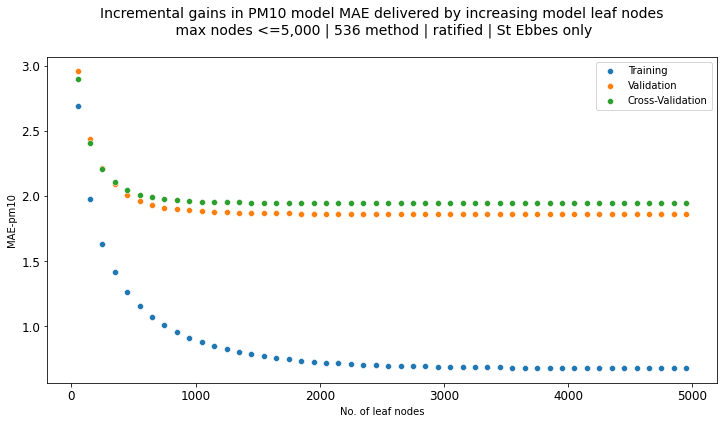

In [11]:
# Plot training & X validation results
#-------------------------------------
test=pd.DataFrame(scores)
plt.figure(figsize=(12,6))

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

sns.scatterplot(x=test.columns,y=test.iloc[1], label='Training')
sns.scatterplot(x=test.columns,y=test.iloc[0], label='Validation')
sns.scatterplot(x=test.columns,y=test.iloc[2], label='Cross-Validation')

plt.ylabel('MAE-pm10')
plt.xlabel('No. of leaf nodes')
plt.title('Incremental gains in PM10 model MAE delivered by increasing model leaf nodes\n \
max nodes <=5,000 | 536 method | ratified | St Ebbes only\n', fontsize=14)

plt.show()

# Save figure if needed
#plt.savefig(pngs+'training_results_pm10_mln5000_e100_sebbes_536_ratified.png', dpi=300)


## Model training

In [12]:
# Redefine the model using best tree size & number
#--------------------------------------------------
model = RandomForestRegressor(max_leaf_nodes=3000,
                              random_state=7,
                              n_estimators=100,
                              n_jobs=-1)

# fit the model
model.fit(train_X, train_y)
model_prediction = model.predict(val_X)


# Validation results

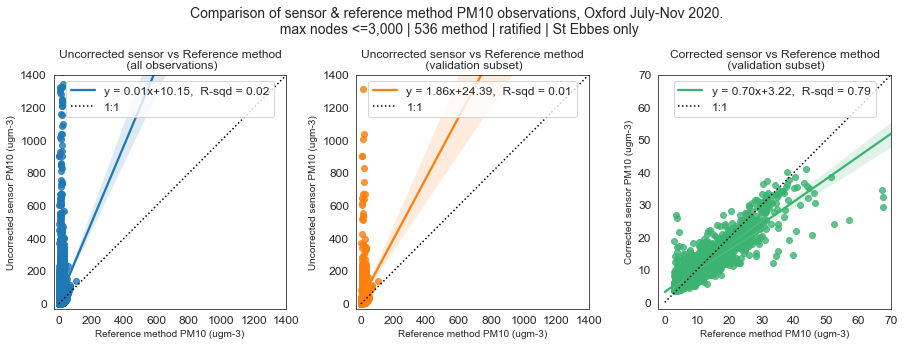

In [13]:
# Plot storyboard of model validation
#-------------------------------------

sns.set_style("white", {'axes.grid' : False})

fig, axes = plt.subplots(1, 3, figsize=(15, 4.3))
fig.suptitle('Comparison of sensor & reference method PM10 observations, Oxford July-Nov 2020. \n \
max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', \
             y=1.1, \
             fontsize=14)


plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

xlim = [0,1200]
axes[0].set_xlim(xlim)

# Get regression stats - sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    train_df['val.pm10_1_c1'], train_df['pm10_ugg_s'])
# Plot it
sns.regplot(x=train_df['pm10_ugg_s'],
            y=train_df['val.pm10_1_c1'],
            color='tab:blue',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[0],
            truncate=False)
axes[0].set(xlabel='Reference method PM10 (ugm-3)',\
            ylabel='Uncorrected sensor PM10 (ugm-3)',\
            title='Uncorrected sensor vs Reference method\n (all observations)',
            xlim=(-30,1400),
            ylim=(-30,1400),
            xticks=(np.arange(0,1500,200)),
            yticks=(np.arange(0,1500,200)))

one = [0, 500, 1400]
sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1.5
            },
            scatter_kws={'s': 0},
            ax=axes[0],ci=None)

axes[1].set_xlim(xlim)

# Recalc regression stats - uncorrected validation subset sensor vs reference method
slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, val_X['val.pm10_1_c1'])
# Plot it
sns.regplot(x=val_y,
            y=val_X['val.pm10_1_c1'],
            color='tab:orange',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[1],
            truncate=False)
axes[1].set(xlabel='Reference method PM10 (ugm-3)',
            ylabel='Uncorrected sensor PM10 (ugm-3)',
            title='Uncorrected sensor vs Reference method\n (validation subset)',
            xlim=(-30,1400),
            ylim=(-30,1400),
            xticks=(np.arange(0,1500,200)),
            yticks=(np.arange(0,1500,200)))

sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1.5
            },
            scatter_kws={'s': 0},
            ax=axes[1],ci=None)

axes[2].set_xlim(0 ,100)

# # Recalc regression stats - corrected validation subset sensor vs reference method 
slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
sns.regplot(x=val_y,
            y=model_prediction,
            color='mediumseagreen',
            line_kws={
                'label':
                "y = {0:.2f}x+{1:.2f},  R-sqd = {3:.2f}".format(
                    slope, intercept, r_value, r_value**2)
            },
            ax=axes[2],
            truncate=False)
axes[2].set(xlabel='Reference method PM10 (ugm-3)',
            ylabel='Corrected sensor PM10 (ugm-3)',
            title='Corrected sensor vs Reference method\n (validation subset)',
            xlim=(-2,70),
            ylim=(-2,70),
            xticks=(np.arange(0,80,10)),
            yticks=(np.arange(0,80,10)))

sns.regplot(x=one,
            y=one,
            color='k',
            line_kws={
                'label': '1:1',
                'ls': ':',
                'lw': 1.5
            },
            scatter_kws={'s': 0},
            ax=axes[2],ci=None)

axes[0].legend(loc="upper center",fontsize=12)
axes[1].legend(loc="upper center",fontsize=12)
axes[2].legend(loc="upper center",fontsize=12)

plt.subplots_adjust(wspace=0.3, hspace=0.31)


##Save figure if needed.
plt.savefig('training_results_pm10_mln3000_e100_sebbes_356_ratified_mar_final.png', dpi=300)

plt.show()


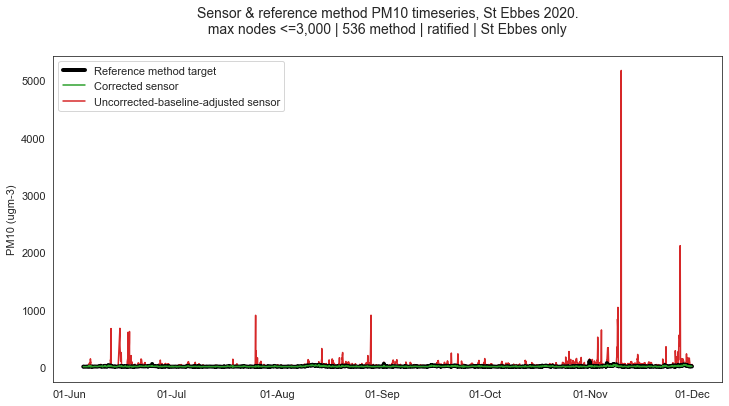

In [14]:
# Create a time series before & after, Jun to Nov
#------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid' : False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

# Model prediction
model_prediction = model.predict(val_X)

#Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=val_y.index.get_level_values(1),
                   y=val_y,
                   label='Reference method target',
                   color='k',
                   lw=4, zorder=2)
ax1 = sns.lineplot(x=val_y.index.get_level_values(1),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green', zorder=3)
ax1 = sns.lineplot(x=val_y.index.get_level_values(1),
                   y=val_X['val.pm10_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:red', zorder=1)
ax1.xaxis.set_major_locator(MonthLocator())
ax1.xaxis.set_major_formatter(myFmt)
#plt.ylim((-5, 80))
ax1.set_title('Sensor & reference method PM10 timeseries, St Ebbes 2020.\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', fontsize=14)

plt.ylabel('PM10 (ugm-3)', fontsize=11)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11,loc='upper left')

#plt.savefig(pngs + 'validation_results_pm10_mln3000_e100_sebbes_356_ratified.png', dpi=300)
plt.show()

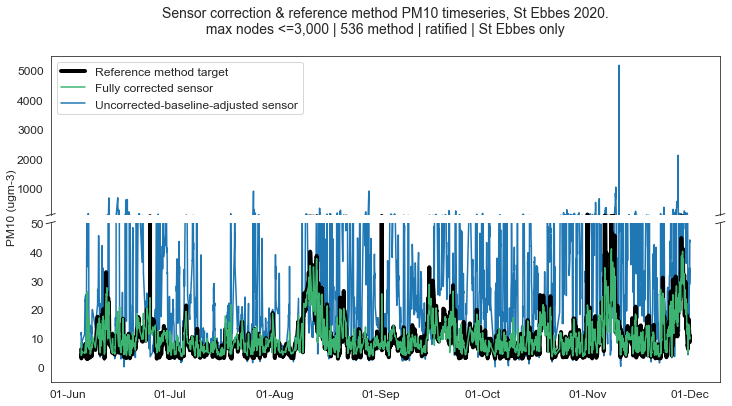

In [15]:
# Plotting the verification results using December 2020 data - split
#--------------------------------------------------------------------

# Model prediction
model_prediction = model.predict(val_X)

sns.set_style("white", {'axes.grid' : False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))

#df = val_y.reset_index()

sns.lineplot(x=val_y.index.get_level_values(1),
                   y=val_y,
                   label='Reference method target',
                   color='k',
                   lw=4, zorder=2, ax=ax)
sns.lineplot(x=val_y.index.get_level_values(1),
                   y=model_prediction,
                   label='Fully corrected sensor',
                   color='mediumseagreen', zorder=3, ax=ax)
sns.lineplot(x=val_y.index.get_level_values(1),
                   y=val_X['val.pm10_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:blue', zorder=1, ax=ax)

sns.lineplot(x=val_y.index.get_level_values(1),
                   y=val_y,
                   #label='AURN target',
                   color='k',
                   lw=4, zorder=2, ax=ax2)
sns.lineplot(x=val_y.index.get_level_values(1),
                   y=model_prediction,
                   #label='Corrected sensor',
                   color='mediumseagreen', zorder=3, ax=ax2)
sns.lineplot(x=val_y.index.get_level_values(1),
                   y=val_X['val.pm10_1_c1'],
                   #label='Uncorrected-baseline-adjusted sensor',
                   color='tab:blue', zorder=1, ax=ax2)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(100,5500)  # outliers only
ax2.set_ylim(-5,50)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05,1.1)
ax.yaxis.label.set_visible(False)

d = .007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('PM10 (ugm-3)', fontsize=12)
plt.xlabel('', fontsize=12)

ax.legend(loc='upper left', fontsize=12)
ax.set_title('Sensor correction & reference method PM10 timeseries, St Ebbes 2020.\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)

plt.savefig('validation_results_pm10_mln3000_e100_sebbes_356_ratified_split_mar_final.png', dpi=300)
plt.show()

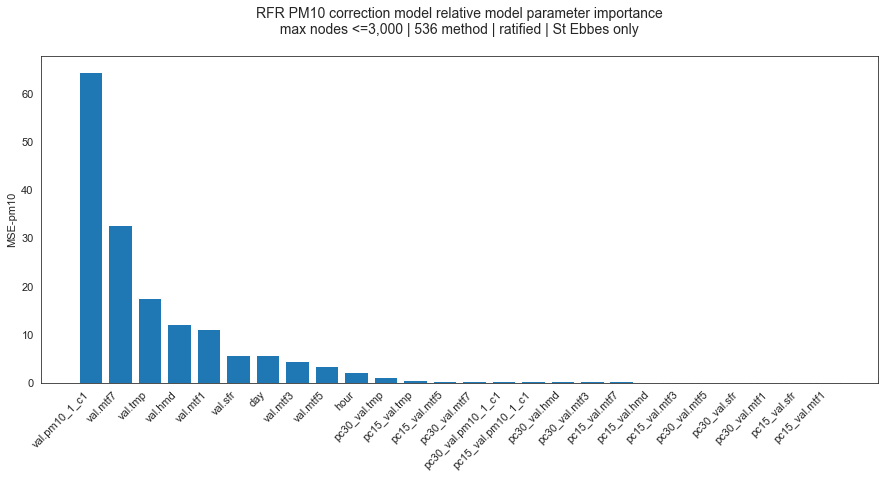

In [16]:
# Permutation importance is a method for determining how important a parameter is by sequentially 
#shuffling model parameters and measuring the effect on model accuracy (MAE in this case) 

# perform permutation importance
results = permutation_importance(model,train_X, train_y, scoring='neg_mean_squared_error')

# get importance
importance = results.importances_mean
importance=pd.DataFrame(importance,index=train_X.columns, columns=['MSE'])
importance=importance.sort_values(by='MSE',ascending=False)

sns.set_style("white", {'axes.grid' : False})

fig = plt.figure(figsize=(15,6))
ax1 = fig.add_subplot(111)
plt.bar(importance.index,importance.MSE);
plt.ylabel('MSE-pm10', fontsize=11)
ax1.xaxis.set_tick_params(rotation=45)
plt.setp(ax1.xaxis.get_majorticklabels(), ha='right', fontsize=12)
plt.title('RFR PM10 correction model relative model parameter importance\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', fontsize=14)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

plt.show()

#Save figure if needed
#plt.savefig(pngs+'parameter_importance_pm10_mln3000_e100_sebbes_356_ratified.png', dpi=300)



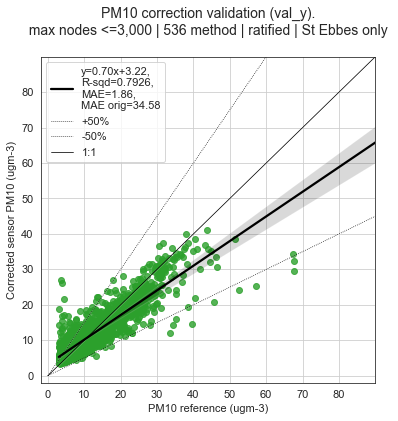

In [17]:
# Plot regression analysis of corrected verification sensor obs vs AURN
#-----------------------------------------------------------------------
sns.set_style("white", {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_X['val.pm10_1_c1'], val_y)

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='tab:green',
    line_kws={
        'label':
        'y={0:.2f}x+{1:.2f},\nR-sqd={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
        format(slope, intercept, r_value**2, mae_veri, mae_orig), #r_value**2
        'color':
        'k'
    })
ax2 = sns.regplot(x=one,
                  y=upper,
                  color='k',
                  line_kws={
                      'label': '+50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax3 = sns.regplot(x=one,
                  y=lower,
                  color='k',
                  line_kws={
                      'label': '-50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax4 = sns.regplot(x=one,
                  y=one,
                  color='k',
                  line_kws={
                      'label': '1:1',
                      'ls': '-',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax1.set_title('PM10 correction validation (val_y).\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', fontsize=14)
ax1.set_xlim(-2, 90)
ax1.set_ylim(-2, 90)
ax1.set_xticks(np.arange(0, 90, 10))
ax1.set_yticks(np.arange(0, 90, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM10 (ugm-3)', fontsize=11)
plt.xlabel('PM10 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
#plt.savefig(pngs + 'validation_regression_pm10_mln3000_e100_sebbes_356_ratified.png',
#            dpi=300)

plt.show()



## Save model

In [18]:
# save the model to disk
#------------------------
filename = rf_home + 'RFR_model_pm10_mln3000_sebbes_val_pm10_1_c2_mar_final.sav'
pickle.dump(model, open(filename, 'wb'))

In [19]:
# Read the saved model to avoid all the working above
#-----------------------------------------------------
model = pickle.load(open(rf_home + 'RFR_model_pm10_mln3000_sebbes_val_pm10_1_c2_mar_final.sav', 'rb'))


In [20]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
#----------------------------------------------------------------------------
import csv

outfile = list(
    zip(val_y.index.get_level_values(1).values, val_y.values, model_prediction))

with open('values_for_cen_calc_3000_pm10_1_c2_mar_final.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ['datetime', 'pm10_ugg_s', 'val.pm10_1_c2'])
    csv_out.writerows(outfile)

mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])
mae_veri = mean_absolute_error(val_y, model_prediction)

print('MAE in uncorrected verifiction data: '+str(mae_orig))
print('MAE in corrected verifiction data: '+str(mae_veri))
print('% 0.1f' % mae_orig,'% 0.1f' % mae_veri)

MAE in uncorrected verifiction data: 34.584526
MAE in corrected verifiction data: 1.8627275610958827
 34.6  1.9


In [21]:
# Constraing verification to  Dec
# --------------------------------
dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)
jan = dt.datetime(2021, 1, 1, 0, 0, 0, tzinfo=pytz.utc)

val_df = sebbes_train_s15_1.query('@dec <= rec < @jan').reset_index().set_index(['tag','rec'])

# Get dec validation data
#-------------------------
validate_df = val_df.loc[:, [
    'val.mtf1',
    'val.mtf5',
    'val.mtf3',
    'val.mtf7',
    'val.sfr',
    'val.hmd',
    'val.tmp',
    'pc15_val.mtf1',
    'pc15_val.mtf5',
    'pc15_val.mtf3',
    'pc15_val.mtf7',
    'pc15_val.sfr',
    'pc15_val.hmd',
    'pc15_val.tmp',
    'pc30_val.mtf1',
    'pc30_val.mtf5',
    'pc30_val.mtf3',
    'pc30_val.mtf7',
    'pc30_val.sfr',
    'pc30_val.hmd',
    'pc30_val.tmp',
    'hour',
    'day',
    'pm10_ugg_s',
    'pm25_ugg_s',
    'pm10_ugg_h',
    'val.pm10_1_c1',
    'pc15_val.pm10_1_c1',
    'pc30_val.pm10_1_c1',
]]

# Drop weirdness in some columns
validate_df = validate_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
train_df = train_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)


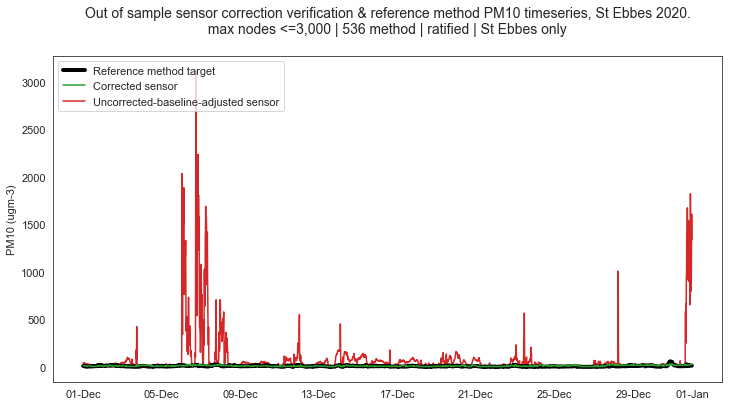

In [22]:
# Plotting the verification results using December 2020 data
#------------------------------------------------------------
myFmt = mdates.DateFormatter('%d-%b')

sns.set_style("white", {'axes.grid': False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

df0 = validate_df.loc[:,'pm10_ugg_s']
df1 = validate_df.drop(columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h'])

# Model prediction
model_prediction = model.predict(df1)

# Plot results
fig = plt.figure(1, figsize=(12, 6))
fig.add_subplot(111)
ax1 = sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0.values,
                   label='Reference method target',
                   color='k',
                   lw=4,
                   zorder=2)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='tab:green',
                   zorder=3)
ax1 = sns.lineplot(x=df1.index.get_level_values(1),
                   y=df1['val.pm10_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:red',
                   zorder=1)

ax1.set_title('Out of sample sensor correction verification & reference method PM10 timeseries, St Ebbes 2020.\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', fontsize=14)
ax1.xaxis.set_major_formatter(myFmt)
#plt.ylim((-5, 80))
plt.ylabel('PM10 (ugm-3)', fontsize=11)
plt.xlabel('')
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=11,loc='upper left')
#plt.savefig(pngs + 'verification_results_pm10_mln3000_sebbes_e100_356_ratified_dec.png', dpi=300)
plt.show()


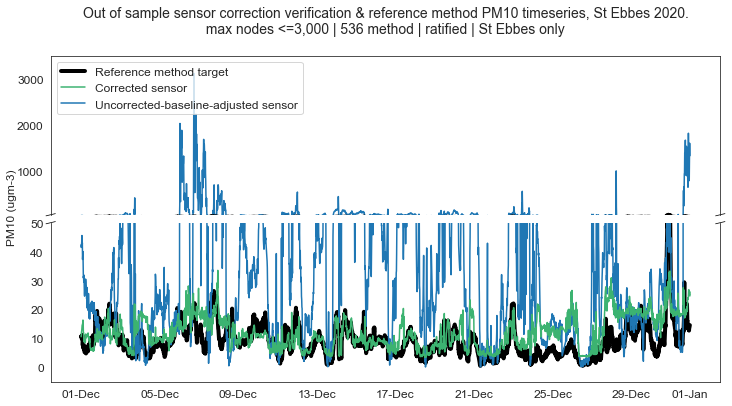

In [24]:
# Plotting the verification results using December 2020 data - split
#--------------------------------------------------------------------
df0 = validate_df.loc[:,'pm10_ugg_s']
df1 = validate_df.drop(columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h'])

# Model prediction
model_prediction = model.predict(df1)

sns.set_style("white", {'axes.grid' : False})

plt.rcParams['ytick.labelsize'] = '12'
plt.rcParams['xtick.labelsize'] = '12'
plt.rcParams['figure.titlesize'] = '12'

myFmt = mdates.DateFormatter('%d-%b')

f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))

#df = val_y.reset_index()

sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0.values,
                   label='Reference method target',
                   color='k',
                   lw=4,
                   zorder=2, ax=ax)
sns.lineplot(x=df1.index.get_level_values(1),
                   y=model_prediction,
                   label='Corrected sensor',
                   color='mediumseagreen',
                   zorder=3, ax=ax)
sns.lineplot(x=df1.index.get_level_values(1),
                   y=df1['val.pm10_1_c1'],
                   label='Uncorrected-baseline-adjusted sensor',
                   color='tab:blue',
                   zorder=1, ax=ax)

sns.lineplot(x=df0.index.get_level_values(1),
                   y=df0.values,
                   color='k',
                   lw=4,
                   zorder=1, ax=ax2)
sns.lineplot(x=df1.index.get_level_values(1),
                   y=model_prediction,
                   color='mediumseagreen',
                   zorder=3, ax=ax2)
sns.lineplot(x=df1.index.get_level_values(1),
                   y=df1['val.pm10_1_c1'],
                   color='tab:blue',
                   zorder=2, ax=ax2)

# zoom-in / limit the view to different portions of the data
ax.set_ylim(60,3500)  # outliers only
ax2.set_ylim(-5,50)  # most of the data

# hide the spines between ax and ax2
ax.spines['bottom'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax.xaxis.set_ticks_position('none')
ax2.yaxis.set_label_coords(-0.05,1.1)
ax.yaxis.label.set_visible(False)

d = .007  # how big to make the diagonal lines in axes coordinates
# arguments to pass to plot, just so we don't keep repeating them
kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
ax2.xaxis.set_major_formatter(myFmt)
kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# What's cool about this is that now if we vary the distance between
# ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# the diagonal lines will move accordingly, and stay right at the tips
# of the spines they are 'breaking'

f.subplots_adjust(hspace=0.05)

plt.ylabel('PM10 (ugm-3)', fontsize=12)
plt.xlabel('', fontsize=12)
ax.legend(loc='upper left', fontsize=12)
ax.set_title('Out of sample sensor correction verification & reference method PM10 timeseries, St Ebbes 2020.\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax2.tick_params(axis="y", labelsize=12)

plt.savefig('verification_results_pm10_mln3000_sebbes_split_356_ratified_dec_split_final.png', dpi=300)

plt.show()

In [23]:
# Save the interesting variables to a csv for CEN expanded uncertainty calcs
#----------------------------------------------------------------------------
import csv

outfile = list(
    zip(df0.index.get_level_values(1).values, df0.values, model_prediction))

with open('values_for_cen_calc_3000_pm10_1_c2_dec_mar_final.csv', 'w') as out:
    csv_out = csv.writer(out)
    csv_out.writerow(
        ['datetime', 'pm10_ugg_s', 'val.pm10_1_c2'])
    csv_out.writerows(outfile)
    

mae_veri = mean_absolute_error(df0.values, model_prediction)
mae_orig = mean_absolute_error(df0.values, df1['val.pm10_1_c1'])

print('MAE in uncorrected verifiction data: '+str(mae_orig))
print('MAE in corrected verifiction data: '+str(mae_veri))
print('% 0.1f' % mae_orig,'% 0.1f' % mae_veri)


MAE in uncorrected verifiction data: 75.45942350228543
MAE in corrected verifiction data: 4.412609717225692
 75.5  4.4


In [24]:
# # Constraing training to Jun to Nov, verification to Dec
# # --------------------------------------------------------

# jul = dt.datetime(2021, 7, 1, 0, 0, 0, tzinfo=pytz.utc)
# dec = dt.datetime(2020, 12, 1, 0, 0, 0, tzinfo=pytz.utc)

# val_df = sebbes_train_s15_1.query('@dec <= rec < @jul').reset_index().set_index(['tag','rec'])

# # Get dec validation data
# #-------------------------
# validate_df = val_df.loc[:, [
#     'val.mtf1',
#     'val.mtf5',
#     'val.mtf3',
#     'val.mtf7',
#     'val.sfr',
#     'val.hmd',
#     'val.tmp',
#     'pc15_val.mtf1',
#     'pc15_val.mtf5',
#     'pc15_val.mtf3',
#     'pc15_val.mtf7',
#     'pc15_val.sfr',
#     'pc15_val.hmd',
#     'pc15_val.tmp',
#     'pc30_val.mtf1',
#     'pc30_val.mtf5',
#     'pc30_val.mtf3',
#     'pc30_val.mtf7',
#     'pc30_val.sfr',
#     'pc30_val.hmd',
#     'pc30_val.tmp',
#     'hour',
#     'day',
#     'pm10_ugg_s',
#     'pm25_ugg_s',
#     'pm10_ugg_h',
#     'pm10_ugg_combo',
#     'val.pm10_1_c1',
#     'pc15_val.pm10_1_c1',
#     'pc30_val.pm10_1_c1',
# ]]

# # Drop weirdness in some columns
# validate_df = validate_df.replace([np.inf, -np.inf], np.nan).dropna(axis=0)
# validate_df.info()

In [25]:
# # Plotting the verification results using December 2020 data - split
# #--------------------------------------------------------------------
# df0 = validate_df.loc[:,'pm10_ugg_combo']
# df1 = validate_df.drop(columns=['pm10_ugg_s', 'pm25_ugg_s', 'pm10_ugg_h','pm10_ugg_combo'])

# # Model prediction
# model_prediction = model.predict(df1)

# sns.set_style("white", {'axes.grid' : False})

# plt.rcParams['ytick.labelsize'] = '12'
# plt.rcParams['xtick.labelsize'] = '12'
# plt.rcParams['figure.titlesize'] = '12'

# myFmt = mdates.DateFormatter('%d-%b')

# f, (ax, ax2) = plt.subplots(2, 1, sharex=True,figsize=(12,6))

# #df = val_y.reset_index()

# sns.lineplot(x=df0.index.get_level_values(1),
#                    y=df0.values,
#                    label='AURN target',
#                    color='k',
#                    lw=4,
#                    zorder=2, ax=ax)
# sns.lineplot(x=df1.index.get_level_values(1),
#                    y=model_prediction,
#                    label='Corrected sensor',
#                    color='tab:green',
#                    zorder=3, ax=ax)
# sns.lineplot(x=df1.index.get_level_values(1),
#                    y=df1['val.pm10_1_c1'],
#                    label='Uncorrected-baseline-adjusted sensor',
#                    color='tab:red',
#                    zorder=1, ax=ax)

# sns.lineplot(x=df0.index.get_level_values(1),
#                    y=df0.values,
#                    color='k',
#                    lw=4,
#                    zorder=2, ax=ax2)
# sns.lineplot(x=df1.index.get_level_values(1),
#                    y=model_prediction,
#                    color='tab:green',
#                    zorder=3, ax=ax2)
# sns.lineplot(x=df1.index.get_level_values(1),
#                    y=df1['val.pm10_1_c1'],
#                    color='tab:red',
#                    zorder=1, ax=ax2)

# # zoom-in / limit the view to different portions of the data
# ax.set_ylim(100,3500)  # outliers only
# ax2.set_ylim(-5,70)  # most of the data

# # hide the spines between ax and ax2
# ax.spines['bottom'].set_visible(False)
# ax2.spines['top'].set_visible(False)
# ax.xaxis.set_ticks_position('none')
# ax2.yaxis.set_label_coords(-0.05,1.1)
# ax.yaxis.label.set_visible(False)

# d = .007  # how big to make the diagonal lines in axes coordinates
# # arguments to pass to plot, just so we don't keep repeating them
# kwargs = dict(transform=ax.transAxes, color='k', clip_on=False, lw=0.75)
# ax.plot((-d, +d), (-d, +d), **kwargs)        # top-left diagonal
# ax.plot((1 - d, 1 + d), (-d, +d), **kwargs)  # top-right diagonal
# ax2.xaxis.set_major_formatter(myFmt)
# kwargs.update(transform=ax2.transAxes)  # switch to the bottom axes
# ax2.plot((-d, +d), (1 - d, 1 + d), **kwargs)  # bottom-left diagonal
# ax2.plot((1 - d, 1 + d), (1 - d, 1 + d), **kwargs)  # bottom-right diagonal

# # What's cool about this is that now if we vary the distance between
# # ax and ax2 via f.subplots_adjust(hspace=...) or plt.subplot_tool(),
# # the diagonal lines will move accordingly, and stay right at the tips
# # of the spines they are 'breaking'

# f.subplots_adjust(hspace=0.05)

# plt.ylabel('PM10 (ugm-3)', fontsize=12)
# ax.legend(loc='upper left', fontsize=12)
# ax.set_title('Out of sample sensor correction verification & reference method PM10 timeseries, St Ebbes 2020.\n \
# max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', fontsize=14)
# plt.xticks(fontsize=12)
# plt.yticks(fontsize=12)
# ax.tick_params(axis="y", labelsize=12)
# ax2.tick_params(axis="y", labelsize=12)

# #plt.savefig(pngs + 'validation_results_pm10_mln3000_sebbes_split_356_ratified_dec_split.png', dpi=300)

# plt.show()

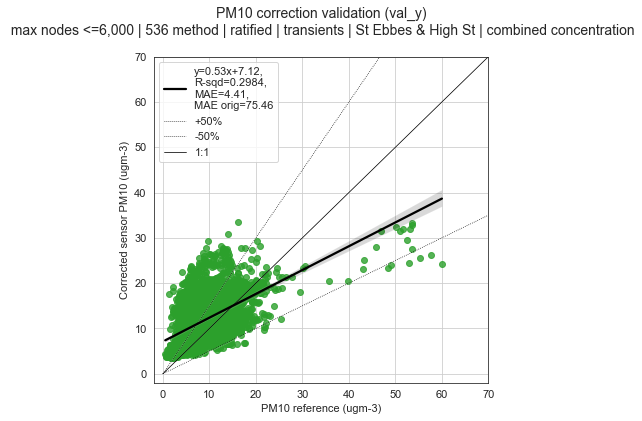

In [26]:
# Plot regression analysis of corrected verification sensor obs vs AURN
#-----------------------------------------------------------------------
sns.set_style("white", {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

# Model prediction
# model_prediction = model.predict(df1)
# df0 = validate_df.loc[:,'pm10_ugg_combo']

dftmp0 = pd.concat([
    df0.reset_index(),
    pd.DataFrame(model_prediction, columns=['model_prediction'])
],
    axis=1).set_index(['tag', 'rec'])

dftmp1 = dftmp0.groupby([
    pd.Grouper(level='tag'),
    pd.Grouper(level='rec',
               freq='1H',
               label='right',
               convention='end',
               origin='epoch')
]).mean()


slope, intercept, r_value, p_value, std_err = stats.linregress(
    dftmp0.iloc[:,0].values, dftmp0.iloc[:,1].values)
mae_veri = mean_absolute_error(dftmp0.iloc[:,0].values, dftmp0.iloc[:,1].values)
#mae_orig = mean_absolute_error(val_y, val_X['val.pm10_1_c1'])

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=dftmp0.iloc[:,0].values,
    y=dftmp0.iloc[:,1].values,
    color='tab:green',
    line_kws={
        'label':
        'y={0:.2f}x+{1:.2f},\nR-sqd={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
        format(slope, intercept, r_value**2, mae_veri, mae_orig),
        'color':
        'k'
    },)
#    scatter_kws={'s': 2})
ax2 = sns.regplot(x=one,
                  y=upper,
                  color='k',
                  line_kws={
                      'label': '+50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax3 = sns.regplot(x=one,
                  y=lower,
                  color='k',
                  line_kws={
                      'label': '-50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax4 = sns.regplot(x=one,
                  y=one,
                  color='k',
                  line_kws={
                      'label': '1:1',
                      'ls': '-',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax1.set_title('PM10 correction validation (val_y)\n \
max nodes <=6,000 | 536 method | ratified | transients | St Ebbes & High St | combined concentration\n', fontsize=14)
ax1.set_xlim(-2, 70)
ax1.set_ylim(-2, 70)
ax1.set_xticks(np.arange(0, 75, 10))
ax1.set_yticks(np.arange(0, 75, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM10 (ugm-3)', fontsize=11)
plt.xlabel('PM10 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)

# Save figure if needed
#plt.savefig(pngs + 'verification_regression_pm10_mln6000_e100_536_sebbes_highs_ratified_combo.png',
#            dpi=300)
plt.show()

In [27]:
# Plot regression analysis of corrected verification sensor obs vs AURN
#-----------------------------------------------------------------------
sns.set_style("white", {'axes.grid': True})

one = [0, 20, 40, 60, 80, 100]
upper = [i * 1.50 for i in one]
lower = [i * 0.50 for i in one]

slope, intercept, r_value, p_value, std_err = stats.linregress(
    val_y, model_prediction)
mae_veri = mean_absolute_error(val_y, model_prediction)
mae_orig = mean_absolute_error(val_X['val.pm10_1_c1'], val_y)

fig = plt.figure(1, figsize=(6, 6))
fig.add_subplot(111)
ax1 = sns.regplot(
    x=val_y,
    y=model_prediction,
    color='tab:green',
    line_kws={
        'label':
        'y={0:.2f}x+{1:.2f},\nR-sqd={2:.4f},\nMAE={3:.2f},\nMAE orig={4:.2f}'.
        format(slope, intercept, r_value**2, mae_veri, mae_orig), #r_value**2
        'color':
        'k'
    })
ax2 = sns.regplot(x=one,
                  y=upper,
                  color='k',
                  line_kws={
                      'label': '+50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax3 = sns.regplot(x=one,
                  y=lower,
                  color='k',
                  line_kws={
                      'label': '-50%',
                      'ls': ':',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax4 = sns.regplot(x=one,
                  y=one,
                  color='k',
                  line_kws={
                      'label': '1:1',
                      'ls': '-',
                      'lw': 0.75
                  },
                  scatter_kws={'s': 0})

ax1.set_title('PM10 correction verification (val_y).\n \
max nodes <=3,000 | 536 method | ratified | St Ebbes only \n', fontsize=14)
ax1.set_xlim(-2, 90)
ax1.set_ylim(-2, 90)
ax1.set_xticks(np.arange(0, 90, 10))
ax1.set_yticks(np.arange(0, 90, 10))
plt.legend(fontsize=11)
plt.ylabel('Corrected sensor PM10 (ugm-3)', fontsize=11)
plt.xlabel('PM10 reference (ugm-3)', fontsize=11)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
#plt.savefig(pngs + 'validation_regression_pm10_mln3000_e100_sebbes_356_ratified.png',
#            dpi=300)

plt.show()



ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 3159 and the array at index 1 has size 2939